<a href="https://colab.research.google.com/github/Magferat/p2_models/blob/main/20_epoch_Train_Rawnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install torch torchaudio matplotlib scikit-learn tqdm ipywidgets notebook soundfile audioread librosa seaborn


In [19]:
# Standard libraries
import os
import random
import math
import pickle

# Numerical and data handling
import numpy as np
import pandas as pd

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import Tensor
from torch.utils.data import Dataset, DataLoader
from torch.utils import data
from torch.nn.parameter import Parameter
from torch.autograd import Variable
from collections import OrderedDict

# Torchaudio
import torchaudio
import torchaudio.transforms as T

# Display
import IPython.display as ipd

# Sklearn metrics and tools
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    precision_score, recall_score, f1_score, roc_auc_score,
    precision_recall_curve, average_precision_score,
    roc_curve, confusion_matrix
)

# SciPy for EER calculation
from scipy.optimize import brentq
from scipy.interpolate import interp1d

# Progress bar
from tqdm import tqdm


import librosa


In [20]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [21]:
dataset_path = '/content/drive/MyDrive/Dataset'
# dataset_path = r"C:\Users\T2420353\detect_dp_fk_24\Dataset"

train_path = os.path.join(dataset_path, 'Train')
test_path = os.path.join(dataset_path, 'Test')


In [22]:
import os
print(os.listdir(train_path)[:10])
print(os.listdir(test_path)[:10])


['Fake_tts_F_P2_D_9.wav', 'Fake_tts_F_P2_D_23.wav', 'Fake_tts_F_P2_D_28.wav', 'Fake_tts_M_P1_D_7.wav', 'Fake_tts_F_P2_D_19.wav', 'Fake_tts_F_P2_D_35.wav', 'Fake_tts_F_P2_D_36.wav', 'Fake_tts_F_P2_D_25.wav', 'Fake_tts_F_P2_D_45.wav', 'Fake_tts_F_P2_D_41.wav']
['Real_M_P29_E_018.wav', 'Real_M_P29_E_017.wav', 'Real_M_P29_E_010.wav', 'Real_M_P29_E_012.wav', 'Real_M_P29_E_001.wav', 'Real_M_P29_E_009.wav', 'Real_M_P29_E_011.wav', 'Real_M_P29_E_013.wav', 'Real_M_P29_E_007.wav', 'Real_M_P29_E_002.wav']


In [23]:
def parse_filename(name):
    name = name.strip()
    if name.startswith('Real'):
        parts = name.replace('.wav', '').split('_')
        return {
            'path': name,
            'label': 0,
            'fake_type': 'Real',
            'gender': 'Female' if parts[1] == 'F' else 'Male',
            'id': parts[2].strip(),
            'set': parts[3].strip(),
            'sentence': int(parts[4])
        }

    elif name.startswith('Fake_tts'):
        parts = name.replace('.wav', '').split('_')
        return {
            'path': name,
            'label': 1,
            'fake_type': 'TTS',
            'gender': 'Female' if parts[2] == 'F' else 'Male',
            'id': parts[3].strip(),
            'set': parts[4].strip(),
            'sentence': int(parts[5])
        }

    elif name.startswith('Fake_vc'):
        parts = name.replace('.wav', '').split('_')
        return {
            'path': name,
            'label': 1,
            'fake_type': 'VC',
            'gender': None,
            'id': parts[2].strip(),
            'set': parts[3].strip(),
            'sentence': int(parts[4])
        }

    else:
        return None


In [24]:


def get_file_df(folder):
    rows = []
    for name in os.listdir(folder):
        if name.endswith('.wav'):
            data = parse_filename(name)
            if data:
                full_path = os.path.join(folder, data['path'])
                try:
                    # wav, sr = librosa.load(full_path, sr=None)
                    wav, sr = librosa.load(full_path, sr=None, res_type='kaiser_fast')
                    duration_sec = len(wav) / sr
                    data['duration'] = duration_sec
                    data['samples'] = len(wav)
                    data['sr'] = sr
                except Exception as e:
                    print(f"Error loading {full_path}: {e}")
                    continue
                data['path'] = full_path  # Use full path now
                rows.append(data)
    return pd.DataFrame(rows)


In [ ]:
df = get_file_df(train_path)
df.to_csv("train_metadata.csv", index=False)


In [26]:
df = pd.read_csv("train_metadata.csv")
df.head()

,path,label,fake_type,gender,id,set,sentence,duration,samples,sr
0,/content/drive/MyDrive/Dataset/Train/Fake_tts_...,1,TTS,Female,P2,D,9,2.389000,57336,24000
1,/content/drive/MyDrive/Dataset/Train/Fake_tts_...,1,TTS,Female,P2,D,23,3.132000,75168,24000
2,/content/drive/MyDrive/Dataset/Train/Fake_tts_...,1,TTS,Female,P2,D,28,3.169958,76079,24000
3,/content/drive/MyDrive/Dataset/Train/Fake_tts_...,1,TTS,Male,P1,D,7,2.848000,68352,24000
4,/content/drive/MyDrive/Dataset/Train/Fake_tts_...,1,TTS,Female,P2,D,19,3.107000,74568,24000


In [27]:



# def pad(x, max_len=64000): #dimdim
#     x_len = x.shape[0]
#     if x_len >= max_len:
#         return x[:max_len]
#     return torch.cat([x] * (max_len // x_len + 1), dim=0)[:max_len]
def pad(x, max_len=64000):
    x_len = x.shape[0]
    if x_len >= max_len:
        return x[:max_len]
    num_repeats = int(max_len / x_len) + 1
    padded_x = np.tile(x.numpy(), num_repeats)[:max_len]
    return torch.tensor(padded_x, dtype=torch.float32)

def init_weights(m):
    if isinstance(m, nn.Linear):
        # torch.nn.init.xavier_uniform(m.weight)
        nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.0001)
    elif isinstance(m, nn.BatchNorm1d):
        pass
    else:
        if hasattr(m, 'weight'):
            nn.init.kaiming_normal_(m.weight, a=0.01)

class AudioDataset(Dataset):
    def __init__(self, dataframe, transform=None, target_sr=16000):
        self.df = dataframe.reset_index(drop=True)
        self.transform = transform
        self.target_sr = target_sr

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        path = row['path']

        # # torchaudio load
        try:
            wav, sr = torchaudio.load(path)
            wav = wav[0]
        except:
          # wav_np, sr = librosa.load(path, sr=None)
          wav_np, sr = librosa.load(path, sr=None, res_type='kaiser_fast')
          wav = torch.tensor(wav_np, dtype=torch.float32)

        # Resample if needed
        if sr != self.target_sr:
            resampler = T.Resample(orig_freq=sr, new_freq=self.target_sr)
            wav = resampler(wav)

        # Silence trim using librosa
        wav_np = wav.numpy()
        wav_trimmed, _ = librosa.effects.trim(wav_np, top_db=20)
        wav = torch.tensor(wav_trimmed, dtype=torch.float32)

        if self.transform:
            wav = self.transform(wav)

        return wav, row['label']


In [28]:
# Setup
df = pd.read_csv("train_metadata.csv")
df = df.sample(frac=1).reset_index(drop=True)
train_df, val_df = train_test_split(df, test_size=0.2, stratify=df['label'])

transform = lambda x: pad(x, max_len=64000)

train_dataset = AudioDataset(train_df, transform=transform)
val_dataset = AudioDataset(val_df, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [29]:
print(f"Train dataset length: {len(train_dataset)}")
print(f"Validation dataset length: {len(val_dataset)}")
print(f"Total dataset length: {len(train_dataset) + len(val_dataset)}")
print(f"dataset length: {len(df)}")


Train dataset length: 4760
Validation dataset length: 1190
Total dataset length: 5950
dataset length: 5950


In [30]:
import IPython.display as ipd

# Use the internal dataframe from train_dataset (already reset)
df = train_dataset.df

# Get real and fake indices
real_indices = df[df['label'] == 0].index.tolist()
fake_indices = df[df['label'] == 1].index.tolist()

# Sample one from each
real_idx = random.choice(real_indices)
fake_idx = random.choice(fake_indices)

# Get audio + label from dataset
real_audio, real_label = train_dataset[real_idx]
fake_audio, fake_label = train_dataset[fake_idx]

# Get corresponding paths
real_path = df.iloc[real_idx]['path']
fake_path = df.iloc[fake_idx]['path']

# Print and play
print(f"Real Audio | Label: {real_label} | Path: {real_path}")
ipd.display(ipd.Audio(real_audio.numpy(), rate=16000))

print(f"Fake Audio | Label: {fake_label} | Path: {fake_path}")
ipd.display(ipd.Audio(fake_audio.numpy(), rate=16000))


Real Audio | Label: 0 | Path: /content/drive/MyDrive/Dataset/Train/Real_M_P36_C_017.wav


Fake Audio | Label: 1 | Path: /content/drive/MyDrive/Dataset/Train/Fake_tts_M_P3_F_004.wav


In [31]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import Tensor
import numpy as np
import math
from torch.utils import data
from collections import OrderedDict
from torch.nn.parameter import Parameter
from torch.autograd import Variable
import pickle
import random

class SincConv(nn.Module):
    @staticmethod
    def to_mel(hz):
        return 2595 * np.log10(1 + hz / 700)

    @staticmethod
    def to_hz(mel):
        return 700 * (10 ** (mel / 2595) - 1)


    def __init__(self, device,out_channels, kernel_size,in_channels=1,sample_rate=16000,
                 stride=1, padding=0, dilation=1, bias=False, groups=1,freq_scale='Mel'):

        super(SincConv,self).__init__()


        if in_channels != 1:

            msg = "SincConv only support one input channel (here, in_channels = {%i})" % (in_channels)
            raise ValueError(msg)

        self.out_channels = out_channels+1
        self.kernel_size = kernel_size
        self.sample_rate=sample_rate

        # Forcing the filters to be odd (i.e, perfectly symmetrics)
        if kernel_size%2==0:
            self.kernel_size=self.kernel_size+1

        self.device=device
        self.stride = stride
        self.padding = padding
        self.dilation = dilation

        if bias:
            raise ValueError('SincConv does not support bias.')
        if groups > 1:
            raise ValueError('SincConv does not support groups.')


        # initialize filterbanks using Mel scale
        NFFT = 512
        f=int(self.sample_rate/2)*np.linspace(0,1,int(NFFT/2)+1)


        if freq_scale == 'Mel':
            fmel=self.to_mel(f) # Hz to mel conversion
            fmelmax=np.max(fmel)
            fmelmin=np.min(fmel)
            filbandwidthsmel=np.linspace(fmelmin,fmelmax,self.out_channels+2)
            filbandwidthsf=self.to_hz(filbandwidthsmel) # Mel to Hz conversion
            self.freq=filbandwidthsf[:self.out_channels]

        elif freq_scale == 'Inverse-mel':
            fmel=self.to_mel(f) # Hz to mel conversion
            fmelmax=np.max(fmel)
            fmelmin=np.min(fmel)
            filbandwidthsmel=np.linspace(fmelmin,fmelmax,self.out_channels+2)
            filbandwidthsf=self.to_hz(filbandwidthsmel) # Mel to Hz conversion
            self.mel=filbandwidthsf[:self.out_channels]
            self.freq=np.abs(np.flip(self.mel)-1) ## invert mel scale


        else:
            fmelmax=np.max(f)
            fmelmin=np.min(f)
            filbandwidthsmel=np.linspace(fmelmin,fmelmax,self.out_channels+2)
            self.freq=filbandwidthsmel[:self.out_channels]

        self.hsupp=torch.arange(-(self.kernel_size-1)/2, (self.kernel_size-1)/2+1)
        self.band_pass=torch.zeros(self.out_channels-1,self.kernel_size)



    def forward(self,x):
        for i in range(len(self.freq)-1):
            fmin=self.freq[i]
            fmax=self.freq[i+1]
            hHigh=(2*fmax/self.sample_rate)*np.sinc(2*fmax*self.hsupp/self.sample_rate)
            hLow=(2*fmin/self.sample_rate)*np.sinc(2*fmin*self.hsupp/self.sample_rate)
            hideal=hHigh-hLow

            self.band_pass[i,:]=Tensor(np.hamming(self.kernel_size))*Tensor(hideal)

        band_pass_filter=self.band_pass.to(self.device)

        self.filters = (band_pass_filter).view(self.out_channels-1, 1, self.kernel_size)

        return F.conv1d(x, self.filters, stride=self.stride,
                        padding=self.padding, dilation=self.dilation,
                         bias=None, groups=1)



class Residual_block(nn.Module):
    def __init__(self, nb_filts, first = False):
        super(Residual_block, self).__init__()
        self.first = first

        if not self.first:
            self.bn1 = nn.BatchNorm1d(num_features = nb_filts[0])

        self.lrelu = nn.LeakyReLU(negative_slope=0.3)

        self.conv1 = nn.Conv1d(in_channels = nb_filts[0], out_channels = nb_filts[1], kernel_size = 3, padding = 1, stride = 1)

        self.bn2 = nn.BatchNorm1d(num_features = nb_filts[1])
        self.conv2 = nn.Conv1d(in_channels = nb_filts[1], out_channels = nb_filts[1], padding = 1, kernel_size = 3, stride = 1)

        if nb_filts[0] != nb_filts[1]:
            self.downsample = True
            self.conv_downsample = nn.Conv1d(in_channels = nb_filts[0], out_channels = nb_filts[1], padding = 0, kernel_size = 1, stride = 1)

        else:
            self.downsample = False
        self.mp = nn.MaxPool1d(3)

    def forward(self, x):
        identity = x
        if not self.first:
            out = self.bn1(x)
            out = self.lrelu(out)
        else:
            out = x

        out = self.conv1(out)
        out = self.bn2(out)
        out = self.lrelu(out)
        out = self.conv2(out)

        if self.downsample:
            identity = self.conv_downsample(identity)

        out += identity
        out = self.mp(out)
        return out





class RawNet(nn.Module):
    def __init__(self, d_args, device):
        super(RawNet, self).__init__()


        self.device=device

        self.Sinc_conv=SincConv(device=self.device, out_channels = d_args['filts'][0], kernel_size = d_args['first_conv'], in_channels = d_args['in_channels'],freq_scale='Mel'
                                    )

        self.first_bn = nn.BatchNorm1d(num_features = d_args['filts'][0])
        self.selu = nn.SELU(inplace=True)
        self.block0 = nn.Sequential(Residual_block(nb_filts = d_args['filts'][1], first = True))
        self.block1 = nn.Sequential(Residual_block(nb_filts = d_args['filts'][1]))
        self.block2 = nn.Sequential(Residual_block(nb_filts = d_args['filts'][2]))
        d_args['filts'][2][0] = d_args['filts'][2][1]
        self.block3 = nn.Sequential(Residual_block(nb_filts = d_args['filts'][2]))
        self.block4 = nn.Sequential(Residual_block(nb_filts = d_args['filts'][2]))
        self.block5 = nn.Sequential(Residual_block(nb_filts = d_args['filts'][2]))
        self.avgpool = nn.AdaptiveAvgPool1d(1)

        self.fc_attention0 = self._make_attention_fc(in_features = d_args['filts'][1][-1], l_out_features = d_args['filts'][1][-1])
        self.fc_attention1 = self._make_attention_fc(in_features = d_args['filts'][1][-1], l_out_features = d_args['filts'][1][-1])
        self.fc_attention2 = self._make_attention_fc(in_features = d_args['filts'][2][-1], l_out_features = d_args['filts'][2][-1])
        self.fc_attention3 = self._make_attention_fc(in_features = d_args['filts'][2][-1], l_out_features = d_args['filts'][2][-1])
        self.fc_attention4 = self._make_attention_fc(in_features = d_args['filts'][2][-1], l_out_features = d_args['filts'][2][-1])
        self.fc_attention5 = self._make_attention_fc(in_features = d_args['filts'][2][-1], l_out_features = d_args['filts'][2][-1])

        self.bn_before_gru = nn.BatchNorm1d(num_features = d_args['filts'][2][-1])
        self.gru = nn.GRU(input_size = d_args['filts'][2][-1], hidden_size = d_args['gru_node'], num_layers = d_args['nb_gru_layer'], batch_first = True)

        self.fc1_gru = nn.Linear(in_features = d_args['gru_node'], out_features = d_args['nb_fc_node'])

        self.fc2_gru = nn.Linear(in_features = d_args['nb_fc_node'], out_features = d_args['nb_classes'],bias=True)

        self.sig = nn.Sigmoid()


    def forward(self, x, y = None,is_test=False):


        nb_samp = x.shape[0]
        len_seq = x.shape[1]
        x=x.view(nb_samp,1,len_seq)

        x = self.Sinc_conv(x)    # Fixed sinc filters convolution
        x = F.max_pool1d(torch.abs(x), 3)
        x = self.first_bn(x)
        x = self.selu(x)

        x0 = self.block0(x)
        y0 = self.avgpool(x0).view(x0.size(0), -1) # torch.Size([batch, filter])
        y0 = self.fc_attention0(y0)
        y0 = self.sig(y0).view(y0.size(0), y0.size(1), -1)  # torch.Size([batch, filter, 1])
        x = x0 * y0 + y0  # (batch, filter, time) x (batch, filter, 1)


        x1 = self.block1(x)
        y1 = self.avgpool(x1).view(x1.size(0), -1) # torch.Size([batch, filter])
        y1 = self.fc_attention1(y1)
        y1 = self.sig(y1).view(y1.size(0), y1.size(1), -1)  # torch.Size([batch, filter, 1])
        x = x1 * y1 + y1 # (batch, filter, time) x (batch, filter, 1)

        x2 = self.block2(x)
        y2 = self.avgpool(x2).view(x2.size(0), -1) # torch.Size([batch, filter])
        y2 = self.fc_attention2(y2)
        y2 = self.sig(y2).view(y2.size(0), y2.size(1), -1)  # torch.Size([batch, filter, 1])
        x = x2 * y2 + y2 # (batch, filter, time) x (batch, filter, 1)

        x3 = self.block3(x)
        y3 = self.avgpool(x3).view(x3.size(0), -1) # torch.Size([batch, filter])
        y3 = self.fc_attention3(y3)
        y3 = self.sig(y3).view(y3.size(0), y3.size(1), -1)  # torch.Size([batch, filter, 1])
        x = x3 * y3 + y3 # (batch, filter, time) x (batch, filter, 1)

        x4 = self.block4(x)
        y4 = self.avgpool(x4).view(x4.size(0), -1) # torch.Size([batch, filter])
        y4 = self.fc_attention4(y4)
        y4 = self.sig(y4).view(y4.size(0), y4.size(1), -1)  # torch.Size([batch, filter, 1])
        x = x4 * y4 + y4 # (batch, filter, time) x (batch, filter, 1)

        x5 = self.block5(x)
        y5 = self.avgpool(x5).view(x5.size(0), -1) # torch.Size([batch, filter])
        y5 = self.fc_attention5(y5)
        y5 = self.sig(y5).view(y5.size(0), y5.size(1), -1)  # torch.Size([batch, filter, 1])
        x = x5 * y5 + y5 # (batch, filter, time) x (batch, filter, 1)

        x = self.bn_before_gru(x)
        x = self.selu(x)
        x = x.permute(0, 2, 1)     #(batch, filt, time) >> (batch, time, filt)
        self.gru.flatten_parameters()
        x, _ = self.gru(x)
        x = x[:,-1,:]
        x = self.fc1_gru(x)
        x = self.fc2_gru(x)

        if not is_test:
            output = x
            return output

        else:
            output=F.softmax(x,dim=1)
            return output




    def _make_attention_fc(self, in_features, l_out_features):

        l_fc = []

        l_fc.append(nn.Linear(in_features = in_features,
			        out_features = l_out_features))



        return nn.Sequential(*l_fc)


    def _make_layer(self, nb_blocks, nb_filts, first = False):
        layers = []
        #def __init__(self, nb_filts, first = False):
        for i in range(nb_blocks):
            first = first if i == 0 else False
            layers.append(Residual_block(nb_filts = nb_filts,
				first = first))
            if i == 0: nb_filts[0] = nb_filts[1]

        return nn.Sequential(*layers)

    # def summary(self, input_size, batch_size=-1, device="cuda", print_fn=None):
    #     if print_fn is None:
    #         print_fn = print
    #     model = self

    #     def register_hook(module):
    #         def hook(module, input, output):
    #             class_name = str(module.__class__).split(".")[-1].split("'")[0]
    #             module_idx = len(summary)

    #             m_key = "%s-%i" % (class_name, module_idx + 1)
    #             summary[m_key] = OrderedDict()
    #             summary[m_key]["input_shape"] = list(input[0].size())
    #             summary[m_key]["input_shape"][0] = batch_size
    #             if isinstance(output, (list, tuple)):
    #                 summary[m_key]["output_shape"] = [
    #                     [-1] + list(o.size())[1:] for o in output
    #                 ]
    #             else:
    #                 summary[m_key]["output_shape"] = list(output.size())
    #                 if len(summary[m_key]["output_shape"]) != 0:
    #                     summary[m_key]["output_shape"][0] = batch_size

    #             params = 0
    #             if hasattr(module, "weight") and hasattr(module.weight, "size"):
    #                 params += torch.prod(torch.LongTensor(list(module.weight.size())))
    #                 summary[m_key]["trainable"] = module.weight.requires_grad
    #             if hasattr(module, "bias") and hasattr(module.bias, "size"):
    #                 params += torch.prod(torch.LongTensor(list(module.bias.size())))
    #             summary[m_key]["nb_params"] = params

    #         if (
    #             not isinstance(module, nn.Sequential)
    #             and not isinstance(module, nn.ModuleList)
    #             and not (module == model)
    #         ):
    #             hooks.append(module.register_forward_hook(hook))

    #     # Handle device input (string or torch.device)
    #     if isinstance(device, torch.device):
    #         device = str(device).split(':')[0]  # Convert torch.device('cuda:0') to 'cuda'
    #     device = device.lower()
    #     assert device in ["cuda", "cpu"], "Input device is not valid, please specify 'cuda' or 'cpu'"

    #     if device == "cuda" and torch.cuda.is_available():
    #         dtype = torch.cuda.FloatTensor
    #     else:
    #         dtype = torch.FloatTensor

    #     if isinstance(input_size, tuple):
    #         input_size = [input_size]
    #     x = [torch.rand(2, *in_size).type(dtype) for in_size in input_size]
    #     summary = OrderedDict()
    #     hooks = []
    #     model.apply(register_hook)
    #     model(*x)
    #     for h in hooks:
    #         h.remove()

    #     print("----------------------------------------------------------------")
    #     line_new = "{:>20}  {:>25} {:>15}".format("Layer (type)", "Output Shape", "Param #")
    #     print(line_new)
    #     print("================================================================")
    #     total_params = 0
    #     total_output = 0
    #     trainable_params = 0
    #     for layer in summary:
    #         line_new = "{:>20}  {:>25} {:>15}".format(
    #             layer,
    #             str(summary[layer]["output_shape"]),
    #             "{0:,}".format(summary[layer]["nb_params"]),
    #         )
    #         total_params += summary[layer]["nb_params"]
    #         total_output += np.prod(summary[layer]["output_shape"])
    #         if "trainable" in summary[layer]:
    #             if summary[layer]["trainable"]:
    #                 trainable_params += summary[layer]["nb_params"]
    #         print_fn(line_new)

    #     print("================================================================")
    #     print(f"Total params: {total_params:,}")
    #     print(f"Trainable params: {trainable_params:,}")
    #     print(f"Non-trainable params: {total_params - trainable_params:,}")
    #     print("----------------------------------------------------------------")

In [32]:
# Model configuration
config = {
    'first_conv': 128,
    'in_channels': 1,
    'filts': [128, [128, 128], [128, 512], [512, 512]],  # Match original
    'nb_fc_node': 1024,
    'gru_node': 1024,
    'nb_gru_layer': 3,
    'nb_classes': 2,
    'nb_samp': 64000
}


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = RawNet(config, device=device).to(device)
model.apply(init_weights)  # Initialize weights

# model.summary()

RawNet(
  (Sinc_conv): SincConv()
  (first_bn): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (selu): SELU(inplace=True)
  (block0): Sequential(
    (0): Residual_block(
      (lrelu): LeakyReLU(negative_slope=0.3)
      (conv1): Conv1d(128, 128, kernel_size=(3,), stride=(1,), padding=(1,))
      (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv1d(128, 128, kernel_size=(3,), stride=(1,), padding=(1,))
      (mp): MaxPool1d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
    )
  )
  (block1): Sequential(
    (0): Residual_block(
      (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (lrelu): LeakyReLU(negative_slope=0.3)
      (conv1): Conv1d(128, 128, kernel_size=(3,), stride=(1,), padding=(1,))
      (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv1d(128, 128, kernel_size=

In [33]:
# Loss and optimizer
weight = torch.FloatTensor([1.0, 1.0]).to(device)  # Weighted loss
criterion = nn.CrossEntropyLoss(weight=weight)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=0.0001)
epochs = 20

In [34]:

history = {
    'accuracy': [],
    'val_accuracy': [],
    'loss': [],
    'val_loss': [],
    'f1_score': [],
    'val_f1_score': [],
    'precision': [],
    'val_precision': [],
    'recall': [],
    'val_recall': [],
}

# Training loop
os.makedirs("models", exist_ok=True)
best_eer = float('inf')
for epoch in range(epochs):
    model.train()
    running_loss = 0
    correct = 0
    total = 0
    train_y_true, train_y_score = [], []  # For training metrics
    print(f"\nEpoch {epoch+1}/{epochs}")
    for i, (x, y) in enumerate(tqdm(train_loader, desc=f"Training Epoch {epoch+1}", leave=False)):
        x, y = x.to(device), y.to(device)
        outputs = model(x, y)
        loss = criterion(outputs, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * x.size(0)
        pred = torch.argmax(outputs, dim=1)
        correct += (pred == y).sum().item()
        total += y.size(0)
        # Collect for precision, recall, F1
        prob = outputs[:, 1].detach()
        train_y_score.extend(prob.cpu().numpy())
        train_y_true.extend(y.cpu().numpy())
        if (i + 1) % 10 == 0:
            print(f"\rBatch {i+1}: Accuracy: {100*correct/total:.2f}%", end="")
    train_loss = running_loss / total
    train_acc = 100 * correct / total
    train_preds = [1 if s > 0.5 else 0 for s in train_y_score]
    train_precision = precision_score(train_y_true, train_preds)
    train_recall = recall_score(train_y_true, train_preds)
    train_f1 = f1_score(train_y_true, train_preds)
    print(f"\nTrain Loss: {train_loss:.4f}, Accuracy: {train_acc:.2f}%, Precision: {train_precision:.4f}, Recall: {train_recall:.4f}, F1 Score: {train_f1:.4f}")

    # Validation
    model.eval()
    val_running_loss = 0
    correct = 0
    total = 0
    y_true, y_score = [], []
    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(device), y.to(device)
            output = model(x, is_test=True)
            val_loss = criterion(output, y)
            val_running_loss += val_loss.item() * x.size(0)
            prob = output[:, 1]
            y_score.extend(prob.cpu().numpy())
            y_true.extend(y.cpu().numpy())
            pred = torch.argmax(output, dim=1)
            correct += (pred == y).sum().item()
            total += y.size(0)
    val_loss = val_running_loss / total
    val_acc = 100 * correct / total
    fpr, tpr, _ = roc_curve(y_true, y_score)
    eer = brentq(lambda x: 1. - x - interp1d(fpr, tpr)(x), 0., 1.)
    preds = [1 if s > 0.5 else 0 for s in y_score]
    val_precision = precision_score(y_true, preds)
    val_recall = recall_score(y_true, preds)
    val_f1 = f1_score(y_true, preds)
    print(f"Validation Loss: {val_loss:.4f}, Accuracy: {val_acc:.2f}%, EER: {eer:.4f}, Precision: {val_precision:.4f}, Recall: {val_recall:.4f}, F1 Score: {val_f1:.4f}")

    # Store metrics
    history['accuracy'].append(train_acc)
    history['val_accuracy'].append(val_acc)
    history['loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['f1_score'].append(train_f1)
    history['val_f1_score'].append(val_f1)
    history['precision'].append(train_precision)
    history['val_precision'].append(val_precision)
    history['recall'].append(train_recall)
    history['val_recall'].append(val_recall)

    # Save checkpoint
    torch.save(model.state_dict(), f"models/epoch_{epoch+1}.pth")
    if eer < best_eer:
        best_eer = eer
        torch.save(model.state_dict(), "models/best.pth")
        print("Best model saved!")




Epoch 1/20


Training Epoch 1:   7%|▋         | 10/149 [00:14<03:11,  1.38s/it]

Batch 10: Accuracy: 71.88%

Training Epoch 1:  13%|█▎        | 20/149 [00:28<02:56,  1.37s/it]

Batch 20: Accuracy: 79.69%

Training Epoch 1:  20%|██        | 30/149 [00:42<02:42,  1.37s/it]

Batch 30: Accuracy: 80.73%

Training Epoch 1:  27%|██▋       | 40/149 [00:57<02:27,  1.35s/it]

Batch 40: Accuracy: 82.27%

Training Epoch 1:  34%|███▎      | 50/149 [01:10<02:13,  1.34s/it]

Batch 50: Accuracy: 82.94%

Training Epoch 1:  40%|████      | 60/149 [01:25<02:03,  1.39s/it]

Batch 60: Accuracy: 83.33%

Training Epoch 1:  47%|████▋     | 70/149 [01:39<01:48,  1.37s/it]

Batch 70: Accuracy: 84.11%

Training Epoch 1:  54%|█████▎    | 80/149 [01:53<01:39,  1.44s/it]

Batch 80: Accuracy: 84.26%

Training Epoch 1:  60%|██████    | 90/149 [02:07<01:27,  1.48s/it]

Batch 90: Accuracy: 85.14%

Training Epoch 1:  67%|██████▋   | 100/149 [02:22<01:13,  1.51s/it]

Batch 100: Accuracy: 85.56%

Training Epoch 1:  74%|███████▍  | 110/149 [02:36<00:57,  1.48s/it]

Batch 110: Accuracy: 86.11%

Training Epoch 1:  81%|████████  | 120/149 [02:50<00:42,  1.48s/it]

Batch 120: Accuracy: 86.54%

Training Epoch 1:  87%|████████▋ | 130/149 [03:03<00:26,  1.42s/it]

Batch 130: Accuracy: 86.51%

Training Epoch 1:  94%|█████████▍| 140/149 [03:17<00:12,  1.44s/it]

Batch 140: Accuracy: 86.99%


Train Loss: 0.3161, Accuracy: 87.21%, Precision: 0.9168, Recall: 0.8104, F1 Score: 0.8604
Validation Loss: 0.3906, Accuracy: 93.95%, EER: 0.0596, Precision: 0.9614, Recall: 0.9299, F1 Score: 0.9454
Best model saved!

Epoch 2/20


Training Epoch 2:   7%|▋         | 10/149 [00:14<03:29,  1.50s/it]

Batch 10: Accuracy: 90.31%

Training Epoch 2:  13%|█▎        | 20/149 [00:28<03:13,  1.50s/it]

Batch 20: Accuracy: 92.03%

Training Epoch 2:  20%|██        | 30/149 [00:42<02:57,  1.49s/it]

Batch 30: Accuracy: 91.46%

Training Epoch 2:  27%|██▋       | 40/149 [00:56<02:37,  1.44s/it]

Batch 40: Accuracy: 92.50%

Training Epoch 2:  34%|███▎      | 50/149 [01:10<02:21,  1.43s/it]

Batch 50: Accuracy: 92.75%

Training Epoch 2:  40%|████      | 60/149 [01:23<02:04,  1.40s/it]

Batch 60: Accuracy: 92.92%

Training Epoch 2:  47%|████▋     | 70/149 [01:37<01:50,  1.40s/it]

Batch 70: Accuracy: 93.21%

Training Epoch 2:  54%|█████▎    | 80/149 [01:51<01:36,  1.39s/it]

Batch 80: Accuracy: 93.48%

Training Epoch 2:  60%|██████    | 90/149 [02:05<01:21,  1.38s/it]

Batch 90: Accuracy: 93.33%

Training Epoch 2:  67%|██████▋   | 100/149 [02:19<01:07,  1.38s/it]

Batch 100: Accuracy: 93.41%

Training Epoch 2:  74%|███████▍  | 110/149 [02:33<00:53,  1.36s/it]

Batch 110: Accuracy: 93.47%

Training Epoch 2:  81%|████████  | 120/149 [02:47<00:40,  1.39s/it]

Batch 120: Accuracy: 93.62%

Training Epoch 2:  87%|████████▋ | 130/149 [03:01<00:26,  1.39s/it]

Batch 130: Accuracy: 93.70%

Training Epoch 2:  94%|█████████▍| 140/149 [03:15<00:11,  1.32s/it]

Batch 140: Accuracy: 93.71%


Train Loss: 0.1602, Accuracy: 93.93%, Precision: 0.9677, Recall: 0.9175, F1 Score: 0.9420
Validation Loss: 0.3446, Accuracy: 97.14%, EER: 0.0254, Precision: 0.9622, Recall: 0.9881, F1 Score: 0.9750
Best model saved!

Epoch 3/20


Training Epoch 3:   7%|▋         | 10/149 [00:14<03:13,  1.39s/it]

Batch 10: Accuracy: 94.69%

Training Epoch 3:  13%|█▎        | 20/149 [00:28<03:02,  1.42s/it]

Batch 20: Accuracy: 93.75%

Training Epoch 3:  20%|██        | 30/149 [00:41<02:42,  1.37s/it]

Batch 30: Accuracy: 94.27%

Training Epoch 3:  27%|██▋       | 40/149 [00:55<02:25,  1.34s/it]

Batch 40: Accuracy: 94.38%

Training Epoch 3:  34%|███▎      | 50/149 [01:09<02:14,  1.36s/it]

Batch 50: Accuracy: 94.19%

Training Epoch 3:  40%|████      | 60/149 [01:23<01:58,  1.33s/it]

Batch 60: Accuracy: 93.85%

Training Epoch 3:  47%|████▋     | 70/149 [01:36<01:46,  1.35s/it]

Batch 70: Accuracy: 94.11%

Training Epoch 3:  54%|█████▎    | 80/149 [01:50<01:33,  1.35s/it]

Batch 80: Accuracy: 94.49%

Training Epoch 3:  60%|██████    | 90/149 [02:04<01:16,  1.30s/it]

Batch 90: Accuracy: 94.31%

Training Epoch 3:  67%|██████▋   | 100/149 [02:18<01:05,  1.34s/it]

Batch 100: Accuracy: 94.47%

Training Epoch 3:  74%|███████▍  | 110/149 [02:32<00:52,  1.35s/it]

Batch 110: Accuracy: 94.63%

Training Epoch 3:  81%|████████  | 120/149 [02:45<00:38,  1.32s/it]

Batch 120: Accuracy: 94.61%

Training Epoch 3:  87%|████████▋ | 130/149 [02:59<00:24,  1.30s/it]

Batch 130: Accuracy: 94.64%

Training Epoch 3:  94%|█████████▍| 140/149 [03:13<00:12,  1.35s/it]

Batch 140: Accuracy: 94.78%


Train Loss: 0.1417, Accuracy: 94.89%, Precision: 0.9697, Recall: 0.9310, F1 Score: 0.9499
Validation Loss: 0.3434, Accuracy: 97.14%, EER: 0.0192, Precision: 0.9923, Recall: 0.9567, F1 Score: 0.9742
Best model saved!

Epoch 4/20


Training Epoch 4:   7%|▋         | 10/149 [00:14<03:07,  1.35s/it]

Batch 10: Accuracy: 98.75%

Training Epoch 4:  13%|█▎        | 20/149 [00:28<02:51,  1.33s/it]

Batch 20: Accuracy: 98.28%

Training Epoch 4:  20%|██        | 30/149 [00:41<02:41,  1.36s/it]

Batch 30: Accuracy: 96.56%

Training Epoch 4:  27%|██▋       | 40/149 [00:55<02:24,  1.32s/it]

Batch 40: Accuracy: 96.56%

Training Epoch 4:  34%|███▎      | 50/149 [01:09<02:09,  1.31s/it]

Batch 50: Accuracy: 96.06%

Training Epoch 4:  40%|████      | 60/149 [01:23<01:59,  1.34s/it]

Batch 60: Accuracy: 96.15%

Training Epoch 4:  47%|████▋     | 70/149 [01:36<01:45,  1.33s/it]

Batch 70: Accuracy: 96.38%

Training Epoch 4:  54%|█████▎    | 80/149 [01:50<01:32,  1.34s/it]

Batch 80: Accuracy: 96.52%

Training Epoch 4:  60%|██████    | 90/149 [02:05<01:25,  1.44s/it]

Batch 90: Accuracy: 96.67%

Training Epoch 4:  67%|██████▋   | 100/149 [02:19<01:11,  1.47s/it]

Batch 100: Accuracy: 96.62%

Training Epoch 4:  74%|███████▍  | 110/149 [02:33<00:57,  1.47s/it]

Batch 110: Accuracy: 96.65%

Training Epoch 4:  81%|████████  | 120/149 [02:47<00:43,  1.48s/it]

Batch 120: Accuracy: 96.64%

Training Epoch 4:  87%|████████▋ | 130/149 [03:00<00:27,  1.46s/it]

Batch 130: Accuracy: 96.71%

Training Epoch 4:  94%|█████████▍| 140/149 [03:14<00:13,  1.45s/it]

Batch 140: Accuracy: 96.81%


Train Loss: 0.0944, Accuracy: 96.81%, Precision: 0.9785, Recall: 0.9515, F1 Score: 0.9648
Validation Loss: 0.3444, Accuracy: 97.23%, EER: 0.0250, Precision: 0.9892, Recall: 0.9612, F1 Score: 0.9750

Epoch 5/20


Training Epoch 5:   7%|▋         | 10/149 [00:13<03:03,  1.32s/it]

Batch 10: Accuracy: 96.25%

Training Epoch 5:  13%|█▎        | 20/149 [00:27<02:52,  1.34s/it]

Batch 20: Accuracy: 96.56%

Training Epoch 5:  20%|██        | 30/149 [00:41<02:34,  1.30s/it]

Batch 30: Accuracy: 97.08%

Training Epoch 5:  27%|██▋       | 40/149 [00:55<02:31,  1.39s/it]

Batch 40: Accuracy: 97.34%

Training Epoch 5:  34%|███▎      | 50/149 [01:09<02:23,  1.45s/it]

Batch 50: Accuracy: 97.12%

Training Epoch 5:  40%|████      | 60/149 [01:22<02:06,  1.42s/it]

Batch 60: Accuracy: 97.03%

Training Epoch 5:  47%|████▋     | 70/149 [01:36<01:56,  1.48s/it]

Batch 70: Accuracy: 97.14%

Training Epoch 5:  54%|█████▎    | 80/149 [01:50<01:41,  1.48s/it]

Batch 80: Accuracy: 97.11%

Training Epoch 5:  60%|██████    | 90/149 [02:04<01:26,  1.47s/it]

Batch 90: Accuracy: 97.15%

Training Epoch 5:  67%|██████▋   | 100/149 [02:18<01:09,  1.43s/it]

Batch 100: Accuracy: 97.25%

Training Epoch 5:  74%|███████▍  | 110/149 [02:32<00:56,  1.44s/it]

Batch 110: Accuracy: 97.30%

Training Epoch 5:  81%|████████  | 120/149 [02:45<00:39,  1.36s/it]

Batch 120: Accuracy: 97.32%

Training Epoch 5:  87%|████████▋ | 130/149 [02:59<00:26,  1.40s/it]

Batch 130: Accuracy: 97.09%

Training Epoch 5:  94%|█████████▍| 140/149 [03:13<00:12,  1.37s/it]

Batch 140: Accuracy: 97.03%


Train Loss: 0.0811, Accuracy: 96.97%, Precision: 0.9842, Recall: 0.9560, F1 Score: 0.9699
Validation Loss: 0.3481, Accuracy: 96.64%, EER: 0.0212, Precision: 0.9565, Recall: 0.9851, F1 Score: 0.9706

Epoch 6/20


Training Epoch 6:   7%|▋         | 10/149 [00:14<03:27,  1.50s/it]

Batch 10: Accuracy: 98.44%

Training Epoch 6:  13%|█▎        | 20/149 [00:28<03:10,  1.48s/it]

Batch 20: Accuracy: 97.66%

Training Epoch 6:  20%|██        | 30/149 [00:42<02:50,  1.43s/it]

Batch 30: Accuracy: 97.71%

Training Epoch 6:  27%|██▋       | 40/149 [00:55<02:34,  1.42s/it]

Batch 40: Accuracy: 98.05%

Training Epoch 6:  34%|███▎      | 50/149 [01:09<02:16,  1.38s/it]

Batch 50: Accuracy: 98.19%

Training Epoch 6:  40%|████      | 60/149 [01:22<02:03,  1.38s/it]

Batch 60: Accuracy: 98.23%

Training Epoch 6:  47%|████▋     | 70/149 [01:36<01:50,  1.40s/it]

Batch 70: Accuracy: 98.17%

Training Epoch 6:  54%|█████▎    | 80/149 [01:50<01:33,  1.36s/it]

Batch 80: Accuracy: 97.93%

Training Epoch 6:  60%|██████    | 90/149 [02:04<01:23,  1.41s/it]

Batch 90: Accuracy: 97.74%

Training Epoch 6:  67%|██████▋   | 100/149 [02:18<01:06,  1.36s/it]

Batch 100: Accuracy: 97.66%

Training Epoch 6:  74%|███████▍  | 110/149 [02:32<00:52,  1.34s/it]

Batch 110: Accuracy: 97.56%

Training Epoch 6:  81%|████████  | 120/149 [02:45<00:38,  1.33s/it]

Batch 120: Accuracy: 97.66%

Training Epoch 6:  87%|████████▋ | 130/149 [02:59<00:25,  1.33s/it]

Batch 130: Accuracy: 97.43%

Training Epoch 6:  94%|█████████▍| 140/149 [03:12<00:11,  1.32s/it]

Batch 140: Accuracy: 97.34%


Train Loss: 0.0753, Accuracy: 97.31%, Precision: 0.9843, Recall: 0.9612, F1 Score: 0.9726
Validation Loss: 0.3354, Accuracy: 98.24%, EER: 0.0173, Precision: 0.9880, Recall: 0.9806, F1 Score: 0.9843
Best model saved!

Epoch 7/20


Training Epoch 7:   7%|▋         | 10/149 [00:14<03:11,  1.37s/it]

Batch 10: Accuracy: 98.75%

Training Epoch 7:  13%|█▎        | 20/149 [00:28<02:58,  1.39s/it]

Batch 20: Accuracy: 98.12%

Training Epoch 7:  20%|██        | 30/149 [00:42<02:46,  1.40s/it]

Batch 30: Accuracy: 96.98%

Training Epoch 7:  27%|██▋       | 40/149 [00:56<02:30,  1.38s/it]

Batch 40: Accuracy: 96.80%

Training Epoch 7:  34%|███▎      | 50/149 [01:10<02:12,  1.34s/it]

Batch 50: Accuracy: 97.06%

Training Epoch 7:  40%|████      | 60/149 [01:23<01:56,  1.31s/it]

Batch 60: Accuracy: 97.29%

Training Epoch 7:  47%|████▋     | 70/149 [01:37<01:45,  1.34s/it]

Batch 70: Accuracy: 97.41%

Training Epoch 7:  54%|█████▎    | 80/149 [01:51<01:33,  1.35s/it]

Batch 80: Accuracy: 97.38%

Training Epoch 7:  60%|██████    | 90/149 [02:05<01:18,  1.33s/it]

Batch 90: Accuracy: 97.47%

Training Epoch 7:  67%|██████▋   | 100/149 [02:19<01:05,  1.33s/it]

Batch 100: Accuracy: 97.34%

Training Epoch 7:  74%|███████▍  | 110/149 [02:32<00:52,  1.34s/it]

Batch 110: Accuracy: 97.50%

Training Epoch 7:  81%|████████  | 120/149 [02:46<00:37,  1.31s/it]

Batch 120: Accuracy: 97.55%

Training Epoch 7:  87%|████████▋ | 130/149 [03:00<00:24,  1.31s/it]

Batch 130: Accuracy: 97.74%

Training Epoch 7:  94%|█████████▍| 140/149 [03:14<00:12,  1.36s/it]

Batch 140: Accuracy: 97.83%


Train Loss: 0.0601, Accuracy: 97.82%, Precision: 0.9878, Recall: 0.9664, F1 Score: 0.9770
Validation Loss: 0.3254, Accuracy: 98.74%, EER: 0.0119, Precision: 0.9925, Recall: 0.9851, F1 Score: 0.9888
Best model saved!

Epoch 8/20


Training Epoch 8:   7%|▋         | 10/149 [00:13<03:09,  1.36s/it]

Batch 10: Accuracy: 96.88%

Training Epoch 8:  13%|█▎        | 20/149 [00:28<02:56,  1.37s/it]

Batch 20: Accuracy: 97.34%

Training Epoch 8:  20%|██        | 30/149 [00:42<02:42,  1.36s/it]

Batch 30: Accuracy: 97.81%

Training Epoch 8:  27%|██▋       | 40/149 [00:56<02:30,  1.38s/it]

Batch 40: Accuracy: 97.81%

Training Epoch 8:  34%|███▎      | 50/149 [01:11<02:23,  1.45s/it]

Batch 50: Accuracy: 97.94%

Training Epoch 8:  40%|████      | 60/149 [01:25<02:07,  1.43s/it]

Batch 60: Accuracy: 97.81%

Training Epoch 8:  47%|████▋     | 70/149 [01:39<02:03,  1.56s/it]

Batch 70: Accuracy: 97.72%

Training Epoch 8:  54%|█████▎    | 80/149 [01:54<01:43,  1.50s/it]

Batch 80: Accuracy: 97.81%

Training Epoch 8:  60%|██████    | 90/149 [02:08<01:25,  1.45s/it]

Batch 90: Accuracy: 97.88%

Training Epoch 8:  67%|██████▋   | 100/149 [02:22<01:11,  1.45s/it]

Batch 100: Accuracy: 98.06%

Training Epoch 8:  74%|███████▍  | 110/149 [02:36<00:55,  1.43s/it]

Batch 110: Accuracy: 98.15%

Training Epoch 8:  81%|████████  | 120/149 [02:50<00:40,  1.40s/it]

Batch 120: Accuracy: 98.23%

Training Epoch 8:  87%|████████▋ | 130/149 [03:04<00:26,  1.38s/it]

Batch 130: Accuracy: 98.05%

Training Epoch 8:  94%|█████████▍| 140/149 [03:17<00:12,  1.36s/it]

Batch 140: Accuracy: 97.99%


Train Loss: 0.0582, Accuracy: 97.98%, Precision: 0.9875, Recall: 0.9713, F1 Score: 0.9793
Validation Loss: 0.3328, Accuracy: 98.91%, EER: 0.0115, Precision: 0.9867, Recall: 0.9940, F1 Score: 0.9903
Best model saved!

Epoch 9/20


Training Epoch 9:   7%|▋         | 10/149 [00:14<03:21,  1.45s/it]

Batch 10: Accuracy: 98.75%

Training Epoch 9:  13%|█▎        | 20/149 [00:27<03:03,  1.42s/it]

Batch 20: Accuracy: 98.75%

Training Epoch 9:  20%|██        | 30/149 [00:41<02:45,  1.39s/it]

Batch 30: Accuracy: 98.65%

Training Epoch 9:  27%|██▋       | 40/149 [00:55<02:27,  1.35s/it]

Batch 40: Accuracy: 98.91%

Training Epoch 9:  34%|███▎      | 50/149 [01:09<02:20,  1.42s/it]

Batch 50: Accuracy: 99.00%

Training Epoch 9:  40%|████      | 60/149 [01:22<02:03,  1.39s/it]

Batch 60: Accuracy: 98.54%

Training Epoch 9:  47%|████▋     | 70/149 [01:36<01:48,  1.37s/it]

Batch 70: Accuracy: 98.21%

Training Epoch 9:  54%|█████▎    | 80/149 [01:50<01:38,  1.43s/it]

Batch 80: Accuracy: 98.32%

Training Epoch 9:  60%|██████    | 90/149 [02:04<01:22,  1.40s/it]

Batch 90: Accuracy: 98.33%

Training Epoch 9:  67%|██████▋   | 100/149 [02:18<01:07,  1.37s/it]

Batch 100: Accuracy: 98.34%

Training Epoch 9:  74%|███████▍  | 110/149 [02:32<00:51,  1.33s/it]

Batch 110: Accuracy: 98.10%

Training Epoch 9:  81%|████████  | 120/149 [02:46<00:39,  1.35s/it]

Batch 120: Accuracy: 98.02%

Training Epoch 9:  87%|████████▋ | 130/149 [03:00<00:25,  1.36s/it]

Batch 130: Accuracy: 98.10%

Training Epoch 9:  94%|█████████▍| 140/149 [03:13<00:12,  1.34s/it]

Batch 140: Accuracy: 98.06%


Train Loss: 0.0546, Accuracy: 98.09%, Precision: 0.9886, Recall: 0.9739, F1 Score: 0.9812
Validation Loss: 0.3379, Accuracy: 97.82%, EER: 0.0254, Precision: 0.9864, Recall: 0.9746, F1 Score: 0.9805

Epoch 10/20


Training Epoch 10:   7%|▋         | 10/149 [00:14<03:18,  1.43s/it]

Batch 10: Accuracy: 96.88%

Training Epoch 10:  13%|█▎        | 20/149 [00:28<02:59,  1.39s/it]

Batch 20: Accuracy: 97.66%

Training Epoch 10:  20%|██        | 30/149 [00:42<02:42,  1.36s/it]

Batch 30: Accuracy: 97.81%

Training Epoch 10:  27%|██▋       | 40/149 [00:56<02:29,  1.37s/it]

Batch 40: Accuracy: 97.58%

Training Epoch 10:  34%|███▎      | 50/149 [01:10<02:12,  1.34s/it]

Batch 50: Accuracy: 97.69%

Training Epoch 10:  40%|████      | 60/149 [01:24<02:00,  1.36s/it]

Batch 60: Accuracy: 98.02%

Training Epoch 10:  47%|████▋     | 70/149 [01:38<01:47,  1.36s/it]

Batch 70: Accuracy: 98.08%

Training Epoch 10:  54%|█████▎    | 80/149 [01:52<01:34,  1.38s/it]

Batch 80: Accuracy: 98.28%

Training Epoch 10:  60%|██████    | 90/149 [02:06<01:23,  1.41s/it]

Batch 90: Accuracy: 98.23%

Training Epoch 10:  67%|██████▋   | 100/149 [02:20<01:09,  1.41s/it]

Batch 100: Accuracy: 98.34%

Training Epoch 10:  74%|███████▍  | 110/149 [02:34<00:57,  1.47s/it]

Batch 110: Accuracy: 98.35%

Training Epoch 10:  81%|████████  | 120/149 [02:48<00:42,  1.47s/it]

Batch 120: Accuracy: 98.36%

Training Epoch 10:  87%|████████▋ | 130/149 [03:02<00:28,  1.49s/it]

Batch 130: Accuracy: 98.25%

Training Epoch 10:  94%|█████████▍| 140/149 [03:16<00:13,  1.47s/it]

Batch 140: Accuracy: 98.28%


Train Loss: 0.0496, Accuracy: 98.26%, Precision: 0.9905, Recall: 0.9739, F1 Score: 0.9821
Validation Loss: 0.3602, Accuracy: 95.46%, EER: 0.0269, Precision: 0.9278, Recall: 0.9970, F1 Score: 0.9612

Epoch 11/20


Training Epoch 11:   7%|▋         | 10/149 [00:14<03:07,  1.35s/it]

Batch 10: Accuracy: 99.06%

Training Epoch 11:  13%|█▎        | 20/149 [00:27<02:53,  1.35s/it]

Batch 20: Accuracy: 99.22%

Training Epoch 11:  20%|██        | 30/149 [00:41<02:49,  1.42s/it]

Batch 30: Accuracy: 99.17%

Training Epoch 11:  27%|██▋       | 40/149 [00:55<02:34,  1.42s/it]

Batch 40: Accuracy: 98.91%

Training Epoch 11:  34%|███▎      | 50/149 [01:09<02:24,  1.46s/it]

Batch 50: Accuracy: 99.00%

Training Epoch 11:  40%|████      | 60/149 [01:23<02:12,  1.49s/it]

Batch 60: Accuracy: 99.06%

Training Epoch 11:  47%|████▋     | 70/149 [01:37<01:53,  1.44s/it]

Batch 70: Accuracy: 98.93%

Training Epoch 11:  54%|█████▎    | 80/149 [01:51<01:40,  1.46s/it]

Batch 80: Accuracy: 98.95%

Training Epoch 11:  60%|██████    | 90/149 [02:05<01:26,  1.46s/it]

Batch 90: Accuracy: 99.03%

Training Epoch 11:  67%|██████▋   | 100/149 [02:19<01:09,  1.41s/it]

Batch 100: Accuracy: 99.03%

Training Epoch 11:  74%|███████▍  | 110/149 [02:33<00:54,  1.39s/it]

Batch 110: Accuracy: 98.89%

Training Epoch 11:  81%|████████  | 120/149 [02:47<00:39,  1.37s/it]

Batch 120: Accuracy: 98.85%

Training Epoch 11:  87%|████████▋ | 130/149 [03:01<00:26,  1.37s/it]

Batch 130: Accuracy: 98.82%

Training Epoch 11:  94%|█████████▍| 140/149 [03:15<00:12,  1.40s/it]

Batch 140: Accuracy: 98.79%


Train Loss: 0.0319, Accuracy: 98.87%, Precision: 0.9928, Recall: 0.9843, F1 Score: 0.9886
Validation Loss: 0.3223, Accuracy: 99.50%, EER: 0.0060, Precision: 1.0000, Recall: 0.9910, F1 Score: 0.9955
Best model saved!

Epoch 12/20


Training Epoch 12:   7%|▋         | 10/149 [00:14<03:14,  1.40s/it]

Batch 10: Accuracy: 99.69%

Training Epoch 12:  13%|█▎        | 20/149 [00:28<02:59,  1.39s/it]

Batch 20: Accuracy: 99.06%

Training Epoch 12:  20%|██        | 30/149 [00:41<02:47,  1.41s/it]

Batch 30: Accuracy: 99.17%

Training Epoch 12:  27%|██▋       | 40/149 [00:55<02:30,  1.38s/it]

Batch 40: Accuracy: 99.06%

Training Epoch 12:  34%|███▎      | 50/149 [01:09<02:16,  1.37s/it]

Batch 50: Accuracy: 99.25%

Training Epoch 12:  40%|████      | 60/149 [01:23<01:59,  1.34s/it]

Batch 60: Accuracy: 99.32%

Training Epoch 12:  47%|████▋     | 70/149 [01:37<01:50,  1.40s/it]

Batch 70: Accuracy: 99.02%

Training Epoch 12:  54%|█████▎    | 80/149 [01:51<01:34,  1.37s/it]

Batch 80: Accuracy: 98.91%

Training Epoch 12:  60%|██████    | 90/149 [02:05<01:19,  1.35s/it]

Batch 90: Accuracy: 98.92%

Training Epoch 12:  67%|██████▋   | 100/149 [02:19<01:06,  1.36s/it]

Batch 100: Accuracy: 98.97%

Training Epoch 12:  74%|███████▍  | 110/149 [02:33<00:53,  1.37s/it]

Batch 110: Accuracy: 98.95%

Training Epoch 12:  81%|████████  | 120/149 [02:48<00:39,  1.38s/it]

Batch 120: Accuracy: 98.85%

Training Epoch 12:  87%|████████▋ | 130/149 [03:02<00:25,  1.36s/it]

Batch 130: Accuracy: 98.94%

Training Epoch 12:  94%|█████████▍| 140/149 [03:16<00:13,  1.47s/it]

Batch 140: Accuracy: 98.93%


Train Loss: 0.0347, Accuracy: 98.89%, Precision: 0.9936, Recall: 0.9828, F1 Score: 0.9882
Validation Loss: 0.3248, Accuracy: 99.16%, EER: 0.0115, Precision: 0.9882, Recall: 0.9970, F1 Score: 0.9926

Epoch 13/20


Training Epoch 13:   7%|▋         | 10/149 [00:14<03:08,  1.35s/it]

Batch 10: Accuracy: 99.69%

Training Epoch 13:  13%|█▎        | 20/149 [00:28<02:54,  1.35s/it]

Batch 20: Accuracy: 98.91%

Training Epoch 13:  20%|██        | 30/149 [00:42<02:37,  1.33s/it]

Batch 30: Accuracy: 99.06%

Training Epoch 13:  27%|██▋       | 40/149 [00:56<02:37,  1.45s/it]

Batch 40: Accuracy: 98.98%

Training Epoch 13:  34%|███▎      | 50/149 [01:10<02:22,  1.44s/it]

Batch 50: Accuracy: 98.81%

Training Epoch 13:  40%|████      | 60/149 [01:24<02:15,  1.52s/it]

Batch 60: Accuracy: 98.85%

Training Epoch 13:  47%|████▋     | 70/149 [01:39<02:01,  1.53s/it]

Batch 70: Accuracy: 98.93%

Training Epoch 13:  54%|█████▎    | 80/149 [01:53<01:43,  1.51s/it]

Batch 80: Accuracy: 99.02%

Training Epoch 13:  60%|██████    | 90/149 [02:07<01:23,  1.41s/it]

Batch 90: Accuracy: 99.10%

Training Epoch 13:  67%|██████▋   | 100/149 [02:21<01:08,  1.40s/it]

Batch 100: Accuracy: 99.03%

Training Epoch 13:  74%|███████▍  | 110/149 [02:35<00:52,  1.35s/it]

Batch 110: Accuracy: 99.03%

Training Epoch 13:  81%|████████  | 120/149 [02:49<00:40,  1.38s/it]

Batch 120: Accuracy: 99.04%

Training Epoch 13:  87%|████████▋ | 130/149 [03:03<00:26,  1.39s/it]

Batch 130: Accuracy: 99.11%

Training Epoch 13:  94%|█████████▍| 140/149 [03:17<00:12,  1.39s/it]

Batch 140: Accuracy: 99.13%


Train Loss: 0.0270, Accuracy: 99.16%, Precision: 0.9940, Recall: 0.9862, F1 Score: 0.9901
Validation Loss: 0.3202, Accuracy: 99.16%, EER: 0.0045, Precision: 0.9970, Recall: 0.9881, F1 Score: 0.9925
Best model saved!

Epoch 14/20


Training Epoch 14:   7%|▋         | 10/149 [00:14<03:18,  1.43s/it]

Batch 10: Accuracy: 100.00%

Training Epoch 14:  13%|█▎        | 20/149 [00:28<02:58,  1.38s/it]

Batch 20: Accuracy: 99.69%

Training Epoch 14:  20%|██        | 30/149 [00:42<02:48,  1.41s/it]

Batch 30: Accuracy: 99.17%

Training Epoch 14:  27%|██▋       | 40/149 [00:56<02:30,  1.38s/it]

Batch 40: Accuracy: 98.52%

Training Epoch 14:  34%|███▎      | 50/149 [01:11<02:14,  1.36s/it]

Batch 50: Accuracy: 98.81%

Training Epoch 14:  40%|████      | 60/149 [01:25<02:01,  1.37s/it]

Batch 60: Accuracy: 98.80%

Training Epoch 14:  47%|████▋     | 70/149 [01:39<01:49,  1.39s/it]

Batch 70: Accuracy: 98.71%

Training Epoch 14:  54%|█████▎    | 80/149 [01:53<01:33,  1.36s/it]

Batch 80: Accuracy: 98.75%

Training Epoch 14:  60%|██████    | 90/149 [02:07<01:23,  1.41s/it]

Batch 90: Accuracy: 98.78%

Training Epoch 14:  67%|██████▋   | 100/149 [02:21<01:08,  1.41s/it]

Batch 100: Accuracy: 98.84%

Training Epoch 14:  74%|███████▍  | 110/149 [02:36<00:58,  1.51s/it]

Batch 110: Accuracy: 98.86%

Training Epoch 14:  81%|████████  | 120/149 [02:50<00:44,  1.53s/it]

Batch 120: Accuracy: 98.88%

Training Epoch 14:  87%|████████▋ | 130/149 [03:05<00:28,  1.48s/it]

Batch 130: Accuracy: 98.73%

Training Epoch 14:  94%|█████████▍| 140/149 [03:19<00:12,  1.44s/it]

Batch 140: Accuracy: 98.64%


Train Loss: 0.0405, Accuracy: 98.66%, Precision: 0.9921, Recall: 0.9810, F1 Score: 0.9865
Validation Loss: 0.3212, Accuracy: 99.41%, EER: 0.0077, Precision: 0.9926, Recall: 0.9970, F1 Score: 0.9948

Epoch 15/20


Training Epoch 15:   7%|▋         | 10/149 [00:14<03:26,  1.48s/it]

Batch 10: Accuracy: 99.69%

Training Epoch 15:  13%|█▎        | 20/149 [00:28<03:14,  1.51s/it]

Batch 20: Accuracy: 99.22%

Training Epoch 15:  20%|██        | 30/149 [00:42<02:54,  1.46s/it]

Batch 30: Accuracy: 99.17%

Training Epoch 15:  27%|██▋       | 40/149 [00:56<02:39,  1.47s/it]

Batch 40: Accuracy: 98.98%

Training Epoch 15:  34%|███▎      | 50/149 [01:10<02:18,  1.40s/it]

Batch 50: Accuracy: 98.88%

Training Epoch 15:  40%|████      | 60/149 [01:24<02:08,  1.44s/it]

Batch 60: Accuracy: 98.75%

Training Epoch 15:  47%|████▋     | 70/149 [01:39<01:50,  1.40s/it]

Batch 70: Accuracy: 98.71%

Training Epoch 15:  54%|█████▎    | 80/149 [01:53<01:37,  1.41s/it]

Batch 80: Accuracy: 98.79%

Training Epoch 15:  60%|██████    | 90/149 [02:07<01:24,  1.43s/it]

Batch 90: Accuracy: 98.89%

Training Epoch 15:  67%|██████▋   | 100/149 [02:21<01:06,  1.36s/it]

Batch 100: Accuracy: 98.88%

Training Epoch 15:  74%|███████▍  | 110/149 [02:36<00:54,  1.40s/it]

Batch 110: Accuracy: 98.92%

Training Epoch 15:  81%|████████  | 120/149 [02:50<00:40,  1.39s/it]

Batch 120: Accuracy: 99.01%

Training Epoch 15:  87%|████████▋ | 130/149 [03:05<00:26,  1.39s/it]

Batch 130: Accuracy: 99.09%

Training Epoch 15:  94%|█████████▍| 140/149 [03:19<00:12,  1.39s/it]

Batch 140: Accuracy: 99.13%


Train Loss: 0.0263, Accuracy: 99.18%, Precision: 0.9947, Recall: 0.9884, F1 Score: 0.9916
Validation Loss: 0.3150, Accuracy: 99.92%, EER: 0.0019, Precision: 0.9985, Recall: 1.0000, F1 Score: 0.9993
Best model saved!

Epoch 16/20


Training Epoch 16:   7%|▋         | 10/149 [00:13<03:03,  1.32s/it]

Batch 10: Accuracy: 100.00%

Training Epoch 16:  13%|█▎        | 20/149 [00:28<02:57,  1.38s/it]

Batch 20: Accuracy: 99.69%

Training Epoch 16:  20%|██        | 30/149 [00:41<02:40,  1.35s/it]

Batch 30: Accuracy: 99.48%

Training Epoch 16:  27%|██▋       | 40/149 [00:55<02:22,  1.31s/it]

Batch 40: Accuracy: 99.53%

Training Epoch 16:  34%|███▎      | 50/149 [01:09<02:15,  1.37s/it]

Batch 50: Accuracy: 99.19%

Training Epoch 16:  40%|████      | 60/149 [01:23<02:05,  1.41s/it]

Batch 60: Accuracy: 99.17%

Training Epoch 16:  47%|████▋     | 70/149 [01:37<01:51,  1.41s/it]

Batch 70: Accuracy: 99.15%

Training Epoch 16:  54%|█████▎    | 80/149 [01:51<01:41,  1.47s/it]

Batch 80: Accuracy: 99.22%

Training Epoch 16:  60%|██████    | 90/149 [02:05<01:28,  1.51s/it]

Batch 90: Accuracy: 99.31%

Training Epoch 16:  67%|██████▋   | 100/149 [02:19<01:13,  1.51s/it]

Batch 100: Accuracy: 99.38%

Training Epoch 16:  74%|███████▍  | 110/149 [02:33<00:56,  1.46s/it]

Batch 110: Accuracy: 99.32%

Training Epoch 16:  81%|████████  | 120/149 [02:47<00:42,  1.46s/it]

Batch 120: Accuracy: 99.14%

Training Epoch 16:  87%|████████▋ | 130/149 [03:01<00:26,  1.40s/it]

Batch 130: Accuracy: 99.01%

Training Epoch 16:  94%|█████████▍| 140/149 [03:15<00:12,  1.41s/it]

Batch 140: Accuracy: 98.91%


Train Loss: 0.0377, Accuracy: 98.89%, Precision: 0.9928, Recall: 0.9840, F1 Score: 0.9884
Validation Loss: 0.3370, Accuracy: 97.39%, EER: 0.0096, Precision: 0.9953, Recall: 0.9582, F1 Score: 0.9764

Epoch 17/20


Training Epoch 17:   7%|▋         | 10/149 [00:14<03:29,  1.50s/it]

Batch 10: Accuracy: 98.75%

Training Epoch 17:  13%|█▎        | 20/149 [00:28<03:03,  1.42s/it]

Batch 20: Accuracy: 98.44%

Training Epoch 17:  20%|██        | 30/149 [00:42<02:47,  1.41s/it]

Batch 30: Accuracy: 98.54%

Training Epoch 17:  27%|██▋       | 40/149 [00:56<02:31,  1.39s/it]

Batch 40: Accuracy: 98.59%

Training Epoch 17:  34%|███▎      | 50/149 [01:10<02:16,  1.37s/it]

Batch 50: Accuracy: 98.75%

Training Epoch 17:  40%|████      | 60/149 [01:24<02:02,  1.38s/it]

Batch 60: Accuracy: 98.85%

Training Epoch 17:  47%|████▋     | 70/149 [01:43<02:12,  1.67s/it]

Batch 70: Accuracy: 98.88%

Training Epoch 17:  54%|█████▎    | 80/149 [01:58<01:40,  1.46s/it]

Batch 80: Accuracy: 98.95%

Training Epoch 17:  60%|██████    | 90/149 [02:12<01:25,  1.45s/it]

Batch 90: Accuracy: 99.06%

Training Epoch 17:  67%|██████▋   | 100/149 [02:26<01:13,  1.51s/it]

Batch 100: Accuracy: 99.12%

Training Epoch 17:  74%|███████▍  | 110/149 [02:42<01:08,  1.75s/it]

Batch 110: Accuracy: 99.20%

Training Epoch 17:  81%|████████  | 120/149 [02:56<00:40,  1.41s/it]

Batch 120: Accuracy: 99.19%

Training Epoch 17:  87%|████████▋ | 130/149 [03:10<00:26,  1.41s/it]

Batch 130: Accuracy: 99.18%

Training Epoch 17:  94%|█████████▍| 140/149 [03:24<00:12,  1.40s/it]

Batch 140: Accuracy: 99.13%


Train Loss: 0.0271, Accuracy: 99.12%, Precision: 0.9947, Recall: 0.9858, F1 Score: 0.9903
Validation Loss: 0.3408, Accuracy: 97.48%, EER: 0.0090, Precision: 1.0000, Recall: 0.9552, F1 Score: 0.9771

Epoch 18/20


Training Epoch 18:   7%|▋         | 10/149 [00:13<03:23,  1.46s/it]

Batch 10: Accuracy: 98.44%

Training Epoch 18:  13%|█▎        | 20/149 [00:27<03:05,  1.44s/it]

Batch 20: Accuracy: 98.59%

Training Epoch 18:  20%|██        | 30/149 [00:41<02:46,  1.40s/it]

Batch 30: Accuracy: 98.85%

Training Epoch 18:  27%|██▋       | 40/149 [00:55<02:30,  1.38s/it]

Batch 40: Accuracy: 99.06%

Training Epoch 18:  34%|███▎      | 50/149 [01:09<02:20,  1.42s/it]

Batch 50: Accuracy: 99.25%

Training Epoch 18:  40%|████      | 60/149 [01:23<02:02,  1.37s/it]

Batch 60: Accuracy: 99.38%

Training Epoch 18:  47%|████▋     | 70/149 [01:37<01:47,  1.36s/it]

Batch 70: Accuracy: 99.46%

Training Epoch 18:  54%|█████▎    | 80/149 [01:51<01:34,  1.37s/it]

Batch 80: Accuracy: 99.38%

Training Epoch 18:  60%|██████    | 90/149 [02:05<01:18,  1.32s/it]

Batch 90: Accuracy: 99.34%

Training Epoch 18:  67%|██████▋   | 100/149 [02:18<01:05,  1.33s/it]

Batch 100: Accuracy: 99.34%

Training Epoch 18:  74%|███████▍  | 110/149 [02:32<00:52,  1.35s/it]

Batch 110: Accuracy: 99.38%

Training Epoch 18:  81%|████████  | 120/149 [02:46<00:38,  1.32s/it]

Batch 120: Accuracy: 99.40%

Training Epoch 18:  87%|████████▋ | 130/149 [03:00<00:25,  1.36s/it]

Batch 130: Accuracy: 99.42%

Training Epoch 18:  94%|█████████▍| 140/149 [03:13<00:11,  1.32s/it]

Batch 140: Accuracy: 99.44%


Train Loss: 0.0203, Accuracy: 99.43%, Precision: 0.9963, Recall: 0.9918, F1 Score: 0.9940
Validation Loss: 0.3173, Accuracy: 99.66%, EER: 0.0030, Precision: 0.9985, Recall: 0.9955, F1 Score: 0.9970

Epoch 19/20


Training Epoch 19:   7%|▋         | 10/149 [00:14<03:15,  1.40s/it]

Batch 10: Accuracy: 99.38%

Training Epoch 19:  13%|█▎        | 20/149 [00:28<03:00,  1.40s/it]

Batch 20: Accuracy: 99.38%

Training Epoch 19:  20%|██        | 30/149 [00:42<02:38,  1.33s/it]

Batch 30: Accuracy: 99.27%

Training Epoch 19:  27%|██▋       | 40/149 [00:56<02:25,  1.33s/it]

Batch 40: Accuracy: 99.22%

Training Epoch 19:  34%|███▎      | 50/149 [01:10<02:13,  1.35s/it]

Batch 50: Accuracy: 99.31%

Training Epoch 19:  40%|████      | 60/149 [01:23<01:55,  1.30s/it]

Batch 60: Accuracy: 99.38%

Training Epoch 19:  47%|████▋     | 70/149 [01:37<01:46,  1.34s/it]

Batch 70: Accuracy: 99.38%

Training Epoch 19:  54%|█████▎    | 80/149 [01:51<01:33,  1.36s/it]

Batch 80: Accuracy: 99.41%

Training Epoch 19:  60%|██████    | 90/149 [02:05<01:24,  1.43s/it]

Batch 90: Accuracy: 99.41%

Training Epoch 19:  67%|██████▋   | 100/149 [02:19<01:09,  1.41s/it]

Batch 100: Accuracy: 99.47%

Training Epoch 19:  74%|███████▍  | 110/149 [02:34<00:59,  1.52s/it]

Batch 110: Accuracy: 99.40%

Training Epoch 19:  81%|████████  | 120/149 [02:48<00:44,  1.52s/it]

Batch 120: Accuracy: 99.45%

Training Epoch 19:  87%|████████▋ | 130/149 [03:02<00:27,  1.45s/it]

Batch 130: Accuracy: 99.47%

Training Epoch 19:  94%|█████████▍| 140/149 [03:15<00:12,  1.43s/it]

Batch 140: Accuracy: 99.51%


Train Loss: 0.0149, Accuracy: 99.52%, Precision: 0.9966, Recall: 0.9929, F1 Score: 0.9948
Validation Loss: 0.3164, Accuracy: 99.75%, EER: 0.0038, Precision: 0.9970, Recall: 0.9985, F1 Score: 0.9978

Epoch 20/20


Training Epoch 20:   7%|▋         | 10/149 [00:14<03:20,  1.44s/it]

Batch 10: Accuracy: 100.00%

Training Epoch 20:  13%|█▎        | 20/149 [00:28<03:08,  1.46s/it]

Batch 20: Accuracy: 99.84%

Training Epoch 20:  20%|██        | 30/149 [00:42<02:57,  1.49s/it]

Batch 30: Accuracy: 99.79%

Training Epoch 20:  27%|██▋       | 40/149 [00:56<02:40,  1.47s/it]

Batch 40: Accuracy: 99.77%

Training Epoch 20:  34%|███▎      | 50/149 [01:10<02:24,  1.46s/it]

Batch 50: Accuracy: 99.81%

Training Epoch 20:  40%|████      | 60/149 [01:24<02:08,  1.44s/it]

Batch 60: Accuracy: 99.79%

Training Epoch 20:  47%|████▋     | 70/149 [01:39<01:52,  1.43s/it]

Batch 70: Accuracy: 99.82%

Training Epoch 20:  54%|█████▎    | 80/149 [01:53<01:39,  1.44s/it]

Batch 80: Accuracy: 99.84%

Training Epoch 20:  60%|██████    | 90/149 [02:07<01:20,  1.37s/it]

Batch 90: Accuracy: 99.83%

Training Epoch 20:  67%|██████▋   | 100/149 [02:21<01:08,  1.39s/it]

Batch 100: Accuracy: 99.84%

Training Epoch 20:  74%|███████▍  | 110/149 [02:35<00:54,  1.39s/it]

Batch 110: Accuracy: 99.86%

Training Epoch 20:  81%|████████  | 120/149 [02:50<00:39,  1.36s/it]

Batch 120: Accuracy: 99.84%

Training Epoch 20:  87%|████████▋ | 130/149 [03:04<00:25,  1.36s/it]

Batch 130: Accuracy: 99.81%

Training Epoch 20:  94%|█████████▍| 140/149 [03:18<00:12,  1.39s/it]

Batch 140: Accuracy: 99.80%


Train Loss: 0.0069, Accuracy: 99.77%, Precision: 0.9981, Recall: 0.9966, F1 Score: 0.9974
Validation Loss: 0.3316, Accuracy: 98.24%, EER: 0.0194, Precision: 0.9894, Recall: 0.9791, F1 Score: 0.9842


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

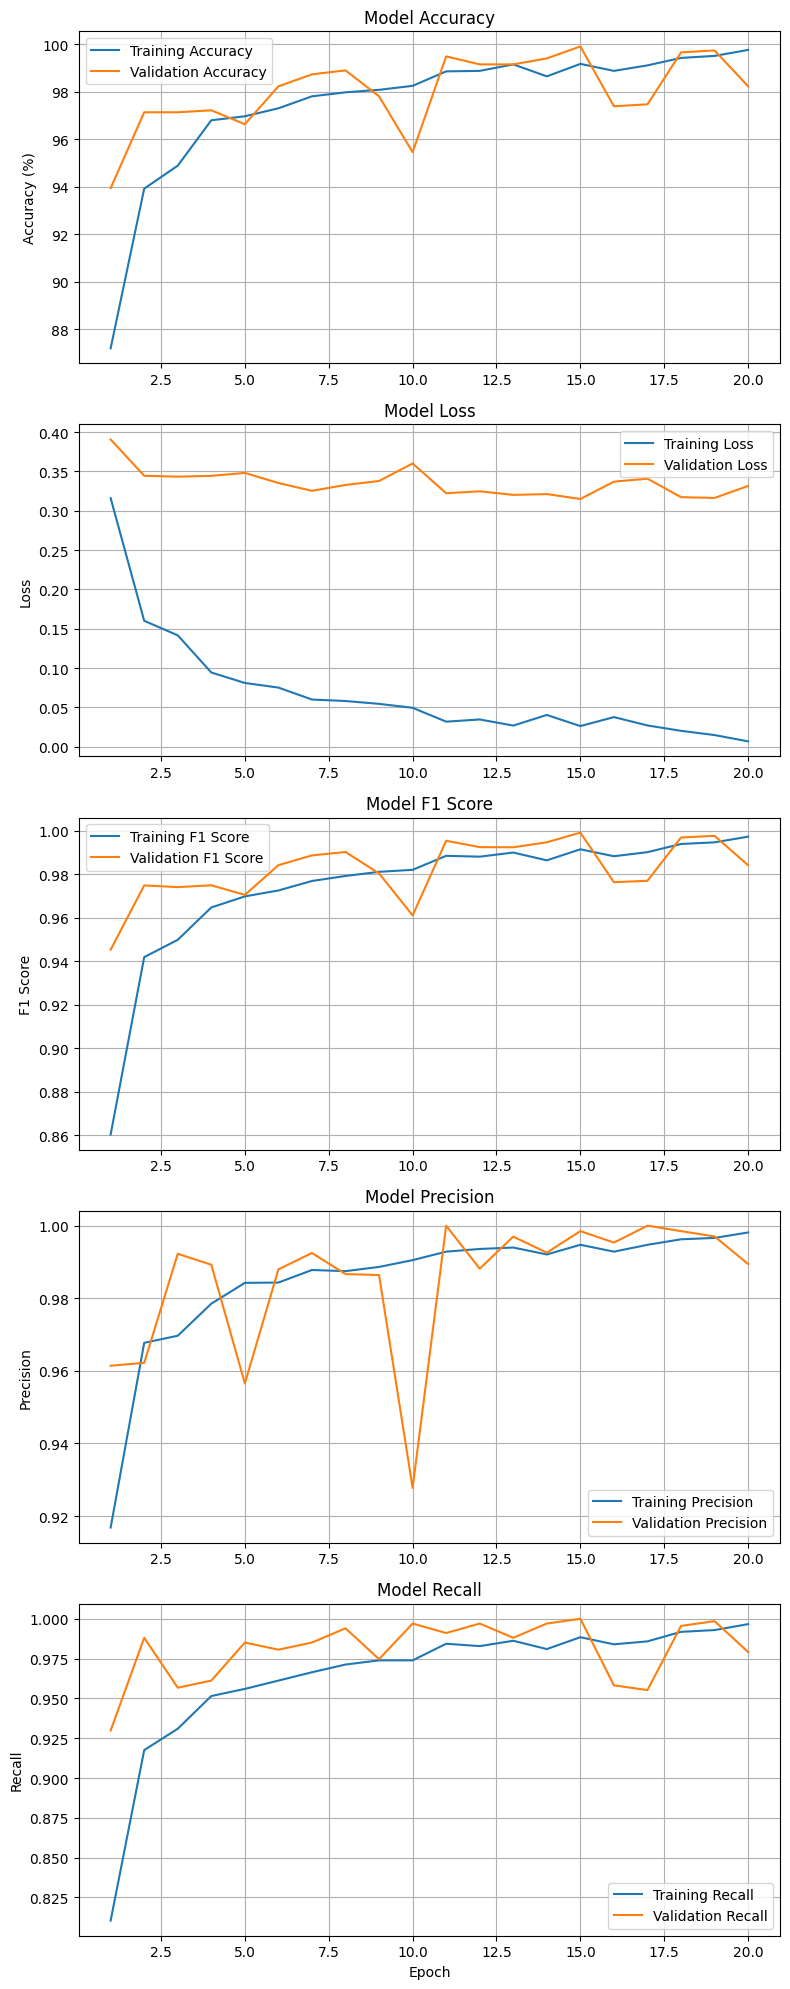

In [35]:
plt.figure(figsize=(8, 20))

# Accuracy
plt.subplot(5, 1, 1)
plt.plot(range(1, len(history['accuracy']) + 1), history['accuracy'], label='Training Accuracy')
plt.plot(range(1, len(history['val_accuracy']) + 1), history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)

# Loss
plt.subplot(5, 1, 2)
plt.plot(range(1, len(history['loss']) + 1), history['loss'], label='Training Loss')
plt.plot(range(1, len(history['val_loss']) + 1), history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# F1 Score
plt.subplot(5, 1, 3)
plt.plot(range(1, len(history['f1_score']) + 1), history['f1_score'], label='Training F1 Score')
plt.plot(range(1, len(history['val_f1_score']) + 1), history['val_f1_score'], label='Validation F1 Score')
plt.title('Model F1 Score')
plt.ylabel('F1 Score')
plt.legend()
plt.grid(True)

# Precision
plt.subplot(5, 1, 4)
plt.plot(range(1, len(history['precision']) + 1), history['precision'], label='Training Precision')
plt.plot(range(1, len(history['val_precision']) + 1), history['val_precision'], label='Validation Precision')
plt.title('Model Precision')
plt.ylabel('Precision')
plt.legend()
plt.grid(True)

# Recall
plt.subplot(5, 1, 5)
plt.plot(range(1, len(history['recall']) + 1), history['recall'], label='Training Recall')
plt.plot(range(1, len(history['val_recall']) + 1), history['val_recall'], label='Validation Recall')
plt.title('Model Recall')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()